## Naive Bayes
Importing all relevant libraries for Data Preparation (importing and cleaning), EDA, ML Model Implementation and Results Evaluation.

In [0]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [0]:
import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/Code1/tools.py')

ModuleNotFoundError: ignored

In [0]:
import pandas as pd
import numpy as np
#import tools as t
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.externals import joblib
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import scale
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")

In [0]:
sns.set()
plt.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)
%load_ext autoreload 
%autoreload 2

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Firstly, we read the dataset into a dataframe using pandas.


In [0]:
df = pd.read_excel("/content/drive/My Drive/Colab Notebooks/Code1/Dataset_final.xlsx")
df.tail()

,user_id_session_date,application_count,application_nunique,category_nunique,battery_delta_sum,amount_session,notification,ratio_notification_opened_session,duration_seconds,night,morning,midday,evening,binary_labels,scores
2232,10947T43540,5,3,2,0,1,0,0.000000,1360.000000,0.000000,0.000000,0.000000,100.000000,0,1.0
2233,10947T43541,62,11,6,9,23,12,0.521739,5461.000000,0.000000,0.000000,59.677419,40.322581,0,1.0
2234,10947T43543,84,8,5,37,2,0,0.000000,5815.000003,0.000000,0.000000,15.476190,84.523810,1,2.0
2235,10947T43544,13,9,6,90,1,0,0.000000,1642.000000,15.384615,7.692308,12.820513,64.102564,0,1.5
2236,10947T43545,61,10,7,58,10,4,0.400000,5051.000001,27.868852,31.147541,0.000000,40.983607,1,2.0


In [0]:
print (df['binary_labels'].value_counts())

0    1385
1     852
Name: binary_labels, dtype: int64


Our dataset is imbalanced ('0' = 1385, '1' = 852) which means data sampling and evaluation must be done carefully.

A concise summary of the dataframe is given below. It shows that there a total of 14 non-null columns. 

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2237 entries, 0 to 2236
Data columns (total 15 columns):
user_id_session_date                 2237 non-null object
application_count                    2237 non-null int64
application_nunique                  2237 non-null int64
category_nunique                     2237 non-null int64
battery_delta_sum                    2237 non-null int64
amount_session                       2237 non-null int64
notification                         2237 non-null int64
ratio_notification_opened_session    2237 non-null float64
duration_seconds                     2237 non-null float64
night                                2237 non-null float64
morning                              2237 non-null float64
midday                               2237 non-null float64
evening                              2237 non-null float64
binary_labels                        2237 non-null int64
scores                               2237 non-null float64
dtypes: float64(7), int

We are going to use the Naive Bayes Classifier. 

In [0]:
#reading all numeric features into X as numpy array
X = np.asarray(df[[u'application_count', u'application_nunique',
       u'category_nunique', u'battery_delta_sum', u'amount_session',
       u'notification', u'ratio_notification_opened_session',
       u'duration_seconds', u'night', u'morning', u'midday', u'evening']].dropna())

#scaling features to avoid dominance of attributes with higher magnitude
X_scaled = scale(X)

#reading target feature in Y
Y = df['binary_labels'].values

Before proceeding for actually implementing Naive Bayes, we just check which features are more important.

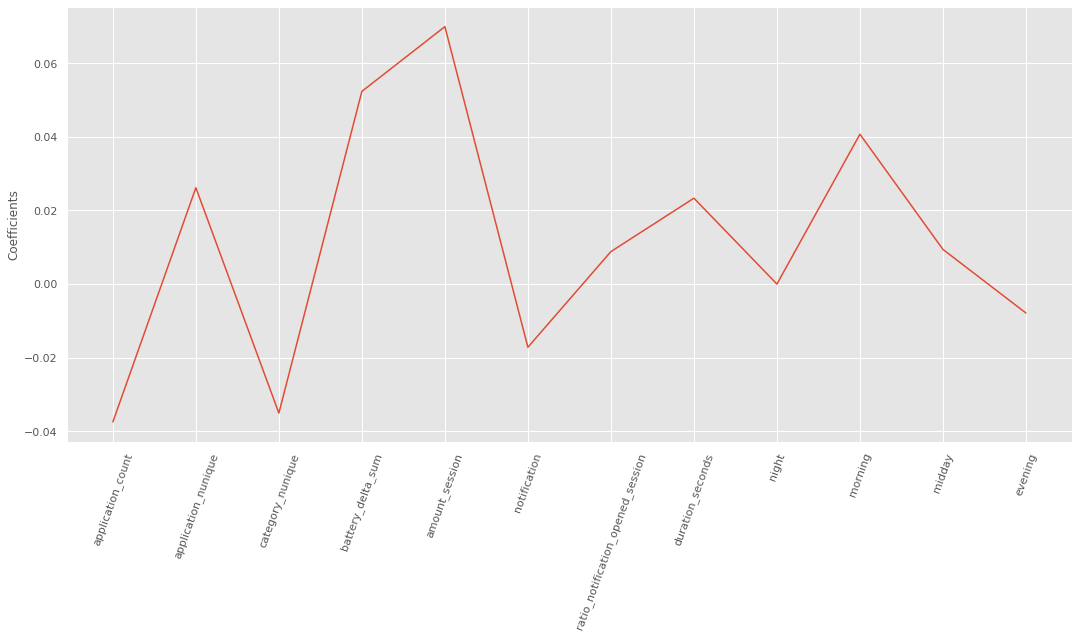

In [0]:
# using lasso for feature selection
names = df[[u'application_count', u'application_nunique',
       u'category_nunique', u'battery_delta_sum', u'amount_session',
       u'notification', u'ratio_notification_opened_session',
       u'duration_seconds', u'night', u'morning', u'midday', u'evening']].columns

lasso = Lasso(alpha=0.001)
lasso_coef = lasso.fit(X_scaled, Y).coef_

plt.figure(figsize=(18,8))
_ = plt.plot(range(len(names)), lasso_coef) 
_ = plt.xticks(range(len(names)), names, rotation=70) 
_ = plt.ylabel('Coefficients') 
plt.show()

As Lasso zero down all unimportant features, we can see from above graph that 'application_nunique', 'battery_delta_sum', 'amount_session', 'ratio_notification_opened_session', 'duration_seconds', 'night', 'morning' and 'midday' are the most significant feature here. Let us just fit our model on these 8 features.

In [0]:
X_new = np.asarray(df[[u'application_nunique', u'battery_delta_sum', u'amount_session',
       u'ratio_notification_opened_session', u'duration_seconds', u'night', u'morning', u'midday']].dropna())
X_new = scale(X_new, with_mean=False)
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X_new, Y, test_size=0.15, random_state=5)
nbc = GaussianNB()
nbc.fit(Xtrain, Ytrain)

GaussianNB(priors=None, var_smoothing=1e-09)

In [0]:
#printing accuracy over 20% test set
y_pred = nbc.predict(Xtest)
print ("Accuracy with best features: ", accuracy_score(y_pred, Ytest))

Accuracy with best features:  0.6279761904761905


Awesome! Accuracy of our model is 62%. But wait, our dataset was imbalanced. So accuracy is not the right evaluation metric and it is better to evaluate on the basis of precision, recall and f1-score.

In [0]:
print (classification_report(Ytest, y_pred))

              precision    recall  f1-score   support

           0       0.67      0.84      0.74       215
           1       0.47      0.25      0.32       121

    accuracy                           0.63       336
   macro avg       0.57      0.54      0.53       336
weighted avg       0.59      0.63      0.59       336



f1-score is 59%. Not bad at all, considering we have not tuned a single parameter. Now lets just use all our features in Naive Bayes and see whether f1-score increases or decreases.

In [0]:
X_scaled = scale(np.asarray(df[[u'application_count', u'application_nunique',
       u'category_nunique', u'battery_delta_sum', u'amount_session',
       u'notification', u'ratio_notification_opened_session',
       u'duration_seconds', u'night', u'morning', u'midday', u'evening']].dropna()))

# Now split data using all features and repeat above process
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X_scaled, Y, test_size=0.2, random_state=5)

# applying fit/predict functions
nbc_full = GaussianNB()
nbc_full.fit(Xtrain, Ytrain)
y_pred = nbc_full.predict(Xtest)

# evaluating predictions using different metrics
print ("Accuracy: ", accuracy_score(y_pred, Ytest))
print ("Classification Report (Precision, Recall, F1-Score)")
print (classification_report(Ytest, y_pred))

Accuracy:  0.6428571428571429
Classification Report (Precision, Recall, F1-Score)
              precision    recall  f1-score   support

           0       0.69      0.80      0.74       286
           1       0.51      0.37      0.43       162

    accuracy                           0.64       448
   macro avg       0.60      0.58      0.58       448
weighted avg       0.62      0.64      0.63       448



Plotting ROC Curve

No handles with labels found to put in legend.


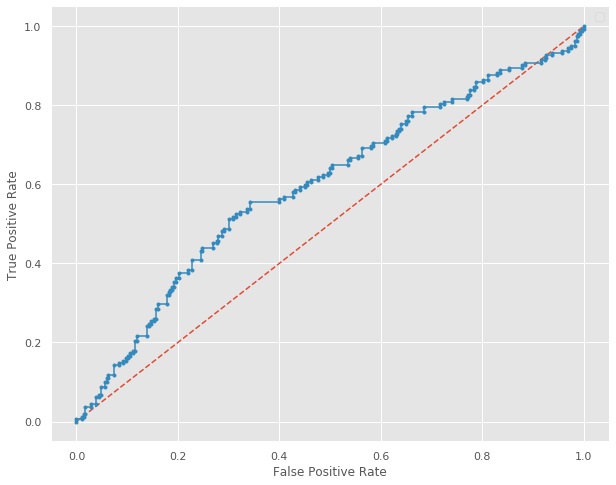

In [0]:
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(Ytest))]
# predict probabilities
lr_probs = nbc_full.predict_proba(Xtest)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(Ytest, ns_probs)
lr_auc = roc_auc_score(Ytest, lr_probs)
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(Ytest, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(Ytest, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--')
plt.plot(lr_fpr, lr_tpr, marker='.')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

<p>By using all features, f1-score increased by 5%.</p>
But look at precision and recall of class 1, it is still low. As we have seen that our dataset was imbalanced, now we will try two different oversampling techniques on best selected features and see how it effects our results.

In [0]:
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler

In [0]:
sos = SMOTE(random_state=12)
X_resampled, y_resampled = sos.fit_sample(X_new, Y)

In [0]:
# Now split data using all features and repeat above process
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=5)

# applying fit/predict functions
nbc_smote = GaussianNB()
nbc_smote.fit(Xtrain, Ytrain)
y_pred = nbc_smote.predict(Xtest)

# evaluating predictions using different metrics
print ("Accuracy: ", accuracy_score(y_pred, Ytest))
print ("Classification Report (Precision, Recall, F1-Score)")
print (classification_report(Ytest, y_pred))

Accuracy:  0.5848375451263538
Classification Report (Precision, Recall, F1-Score)
              precision    recall  f1-score   support

           0       0.56      0.66      0.61       268
           1       0.62      0.51      0.56       286

    accuracy                           0.58       554
   macro avg       0.59      0.59      0.58       554
weighted avg       0.59      0.58      0.58       554



In [0]:
ros = RandomOverSampler(random_state=12)
X_resampled, y_resampled = ros.fit_sample(X_new, Y)

In [0]:
# Now split data using all features and repeat above process
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=5)

# applying fit/predict functions
nbc_ros = GaussianNB()
nbc_ros.fit(Xtrain, Ytrain)
y_pred = nbc_ros.predict(Xtest)

# evaluating predictions using different metrics
print ("Accuracy: ", accuracy_score(y_pred, Ytest))
print ("Classification Report (Precision, Recall, F1-Score)")
print (classification_report(Ytest, y_pred))

Accuracy:  0.5938628158844765
Classification Report (Precision, Recall, F1-Score)
              precision    recall  f1-score   support

           0       0.57      0.69      0.62       268
           1       0.64      0.50      0.56       286

    accuracy                           0.59       554
   macro avg       0.60      0.60      0.59       554
weighted avg       0.60      0.59      0.59       554



Both f1-score and accuracy now seems to be more balanced. There is noteworthy improvement in precision and recall of class 1. Random oversampling performs significantly better than SMOTE. Now lets try undersampling.

In [0]:
from imblearn.under_sampling import RandomUnderSampler

In [0]:
rus = RandomUnderSampler(random_state=12)
X_resampled, y_resampled = rus.fit_sample(X_new, Y)

In [0]:
# Now split data using all features and repeat above process
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=5)

# applying fit/predict functions
nbc_rus = GaussianNB()
nbc_rus.fit(Xtrain, Ytrain)
y_pred = nbc_rus.predict(Xtest)

# evaluating predictions using different metrics
print ("Accuracy: ", accuracy_score(y_pred, Ytest))
print ("Classification Report (Precision, Recall, F1-Score)")
print (classification_report(Ytest, y_pred))

Accuracy:  0.5718475073313783
Classification Report (Precision, Recall, F1-Score)
              precision    recall  f1-score   support

           0       0.54      0.75      0.63       165
           1       0.63      0.41      0.50       176

    accuracy                           0.57       341
   macro avg       0.59      0.58      0.56       341
weighted avg       0.59      0.57      0.56       341



<b>Conclusion: </b>Oversampling yields better results than undersampling.

Finally, lets visualize the our data distribution and decision boundary of our best performing model for better understanding.

In [0]:
X_new = np.asarray(df[[u'duration_seconds', u'midday']].dropna())
X_new = scale(X_new, with_mean=False)

ros = RandomOverSampler(random_state=12)
X_resampled, y_resampled = ros.fit_sample(X_new, Y)

Data distribution can be seen below. Looks quite overlapped.

In [0]:
#t.plotCov(X_new, Y, labels=[u'duration_seconds', u'midday'])

In [0]:
# Now split data using all features and repeat above process
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=5)

# applying fit/predict functions
nbc_ros = GaussianNB()
nbc_ros.fit(Xtrain, Ytrain)
y_pred = nbc_ros.predict(Xtest)

Decision boundaries of trained model can be viewed below. Its is evident that the data is too overlapped and not linearly separable.

In [0]:
tools.plot_decision_regions(Xtrain, Ytrain, clf=nbc_ros, res=0.02, cycle_marker=True, legend=1)

NameError: ignored

## Saving Best Model

In [0]:
joblib.dump(nbc_ros, 'NaiveBayes.joblib')